# Multi-Factor Models

This first part of this notebook summarizes a simple economic model that leads to a multi-factor representation of the expected returns. The second part tests a multi-factor model by OLS.

## Load Packages and Extra Functions

In [1]:
using Dates, DelimitedFiles, Statistics, LinearAlgebra

include("jlFiles/printmat.jl")
include("jlFiles/printTable.jl")
include("jlFiles/OlsGMFn.jl")

OlsGMFn

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :svg)

# Portfolio Choice with Background Risk

Recall: the investor maximizes
$\text{E}R_{p}-\frac{k}{2}\text{Var}(R_{p})$, where 

$R_{p}=v^{\prime}R+\phi R_{H}+(1-\mathbf{1}^{\prime}v-\phi)R_{f}$

Notice that $\text{E}R_{p} = u'[\mu^e;\mu_H^e] + R_f$, where $u = [v;\phi]$ and where $\mu^e$ is the vector of excess returns on the risky assets and $\mu_H^e$ is the excess return on the background risk. 

Also, $\text{Var}(R_{p}) = u'\Omega u$ where 

$
\Omega=\begin{bmatrix}
\Sigma & S_{H}\\
S_{H}^{\prime} & \sigma_{HH}
\end{bmatrix}
$,

where $S_{H}$ is a vector of covariances of the risky assets with the background risk,
and $\sigma_{HH}$ is the variance of the background risk.

In [3]:
function EU(v,ϕ,k,μᵉ,Σ,SH,σHH=0.01,μᵉH=0.02,Rf=0)  #expected utility for the case with background risk
    u     = [v;ϕ]
    μᵉAll = [μᵉ;μᵉH]
    ERp   = u'μᵉAll + Rf
    Ω     = [[Σ SH];[SH' σHH]]
    VarRp = u'Ω*u
    EUtil = ERp - k/2*VarRp
    return EUtil
end

function PortFOpt(ϕ,k,μᵉ,Σ,SH)  #optimal weight on risky asset, ϕ in background, 1-v-ϕ in Rf
    vopt  = inv(Σ)*(μᵉ/k-ϕ*SH)
    wopt  = vopt/(1-ϕ)          #weight on risky in financial subportfolio
    return vopt, wopt
end

PortFOpt (generic function with 1 method)

## One Risky Asset

In [4]:
Σ    = 0.08^2                 #covariance (matrix) of risky assets, here only 1
SH_A = 0                      #covariance(s) of risky with background, case A  
SH_C = 0.0025                 #case C
(μᵉ,k,Rf) = (0.065,25,0.03)

v = range(-0.5,stop=1,length=51)  #weight on risky investable asset
L = length(v)

EUM = fill(NaN,(L,3))                   #try different v values
for i = 1:L
    EUM[i,1] = EU(v[i],0,k,μᵉ,Σ,SH_A)
    EUM[i,2] = EU(v[i],0.5,k,μᵉ,Σ,SH_A)
    EUM[i,3] = EU(v[i],0.5,k,μᵉ,Σ,SH_C)
end

(vA,wA) = PortFOpt(0,k,μᵉ,Σ,SH_A)
(vB,wB) = PortFOpt(0.5,k,μᵉ,Σ,SH_A)
(vC,wC) = PortFOpt(0.5,k,μᵉ,Σ,SH_C)

printblue("\nOptimal weight on (a single) risky asset in the three cases:")
xx = [vA wA;vB wB;vC wC]
colNames = ["in total portf","in financial portf"]
rowNames = ["ϕ=0","ϕ=0.5, σiH=0","ϕ=0.5, σiH>0"]
printTable(xx,colNames,rowNames,width=20)


Optimal weight on (a single) risky asset in the three cases:
                  in total portf  in financial portf
ϕ=0                        0.406               0.406
ϕ=0.5, σiH=0               0.406               0.812
ϕ=0.5, σiH>0               0.211               0.422



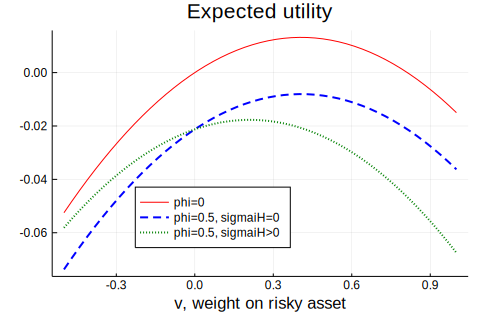

In [5]:
plot( v,EUM,
      linecolor = [:red :blue :green],
      linestyle = [:solid :dash :dot],
      linewidth = [1 2 2],
      label = ["phi=0" "phi=0.5, sigmaiH=0 " "phi=0.5, sigmaiH>0"],
      legend = :bottom,
      title = "Expected utility",
      xlabel = "v, weight on risky asset" )

In [6]:
(vD,wD) = PortFOpt(-0.5,k,μᵉ,Σ,SH_A)       #liability, ϕ<0
(vE,wE) = PortFOpt(-0.5,k,μᵉ,Σ,SH_C)

printblue("\nOptimal weight on (a single) risky asset in the three cases:")
xx = [vA wA;vD wD;vE wE]
colNames = ["in total portf","in financial portf"]
rowNames = ["ϕ=0","ϕ=-0.5, σiH=0","ϕ=-0.5, σiH>0"]
printTable(xx,colNames,rowNames,width=20)


Optimal weight on (a single) risky asset in the three cases:
                   in total portf  in financial portf
ϕ=0                         0.406               0.406
ϕ=-0.5, σiH=0               0.406               0.271
ϕ=-0.5, σiH>0               0.602               0.401



## Several Risky Assets

In [7]:
μ = [11.5; 9.5; 6]/100          #expected returns
Σ  = [166  34  58;              #covariance matrix
       34  64   4;
       58   4 100]/100^2
Rf = 0.03

ϕ   = 0.3                            #fraction of background risk in overall portfolio
σHH = 0.25^2
SH  = [0.5;0.9;-0.1].*sqrt(σHH).*sqrt.(diag(Σ))
μH  = 0.1 
k   = 8

(v,w) = PortFOpt(ϕ,k,μ.-Rf,Σ,SH)

println("optimal weights (inside financial subportfolio):")
printTable([w;1-sum(w)],[""],["A","B","C","Rf"])

optimal weights (inside financial subportfolio):
            
A      0.235
B      0.453
C      0.488
Rf    -0.176



# Asset Pricing Implications of Background Risk: Multi-Factor Model

In [8]:
μᵉF = [0.08,0.089]            #avg. excess returns of factors

Ψ = [1 0.5;                   #covariance matrix of [Rm,RH]
     0.5 2]
SH = [0.8;-0.5]                  #Cov(Ri,Rm) and Cov(Ri,RH)

βmult = inv(Ψ)*SH               #coeffs in Ri = βmult'[Rm;RH]
printlnPs("The multiple regression coefficients: ")
printmat(βmult)

μᵉ = βmult'μᵉF
printlnPs("μᵉ according to 2-factor model:")
printmat(μᵉ)

The multiple regression coefficients: 
     1.057
    -0.514

μᵉ according to 2-factor model:
     0.039



# Empirical Test of a 3-Factor Model: Loading Data

In [9]:
x    = readdlm("Data/FFmFactorsPs.csv",',',skipstart=1)
Rme  = x[:,2]                #market excess return
RSMB = x[:,3]                #small minus big firms
RHML = x[:,4]                #high minus low book-to-market ratio
Rf   = x[:,5]                #interest rate


x  = readdlm("Data/FF25Ps.csv",',') #no header line: x is matrix
R  = x[:,2:end]                     #returns for 25 FF portfolios
Re = R .- Rf                        #excess returns for the 25 FF portfolios
Re = Re[:,[1,7,13,19,25]]           #use just 5 assets to make the printing easier 

(T,n) = size(Re)                    #no. obs and  no. test assets

(388, 5)

## OLS Estimation and Testing α = 0

Recall: estimate $(\alpha_{i},b_{i})$ in the factor model

$R_{it}^{e}  =\alpha_{i}+b_{i}'f_{t} + \varepsilon_{it}$

Test if $\alpha_{i}=0$

In [10]:
x   = [ones(T) Rme RSMB RHML]         #regressors

(α,tstat) = (fill(NaN,n),fill(NaN,n))
for i = 1:n                              #loop over the different test assets
    #local b_i,Covb                      #only needed in REPL/script
    (b_i,_,_,Covb,_) = OlsGMFn(Re[:,i],x)
    α[i]      = b_i[1]
    tstat[i] = (b_i[1]-0)/sqrt(Covb[1,1])  #b_i[1]==0?
end

printblue("Regression of Re on constant and 3 factors:")
colNames = [string("asset ",i) for i=1:n]
printTable([α';tstat'],colNames,["α","t-stat"])

Regression of Re on constant and 3 factors:
         asset 1   asset 2   asset 3   asset 4   asset 5
α         -0.513    -0.006     0.030    -0.020    -0.015
t-stat    -2.306    -0.066     0.328    -0.206    -0.133

